In [9]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt

In [10]:
with open("input.txt", "r", encoding="utf-8") as f:
    text = f.read()

In [11]:
chars = sorted(list(set(text)))    # vocab build
vocab_size = len(chars)
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}
encode = lambda s: [stoi.get(c, 0) for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

In [12]:
data = torch.tensor(encode(text), dtype=torch.long)  # encode dataset
train_data = data[:int(0.9 * len(data))]
val_data = data[int(0.9 * len(data)):]

In [13]:
batch_size = 32        #hyperparameters for the transformer layer
block_size = 32
n_embd = 64
device = 'cuda' if torch.cuda.is_available() else 'cpu'
learning_rate = 1e-3
max_iters = 1000
eval_interval = 100


In [14]:
def get_batch(split):            # batch loader
    d = train_data if split == 'train' else val_data
    ix = torch.randint(len(d) - block_size, (batch_size,))
    x = torch.stack([d[i:i+block_size] for i in ix])
    y = torch.stack([d[i+1:i+block_size+1] for i in ix])
    return x.to(device), y.to(device)

In [ ]:
class Transformer(nn.Module):              #transformer
    def __init__(self, vocab_size, n_embd, block_size):
        super().__init__()
        self.token_emb = nn.Embedding(vocab_size, n_embd)
        self.pos_emb = nn.Embedding(block_size, n_embd)
        self.attn = nn.MultiheadAttention(n_embd, num_heads=2, dropout=0.1, batch_first=True)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ff = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd)
        )
        self.ln2 = nn.LayerNorm(n_embd)
        self.head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_emb = self.token_emb(idx)
        pos_emb = self.pos_emb(torch.arange(T, device=idx.device))
        x = tok_emb + pos_emb
        x = self.ln1(x)

        mask = torch.tril(torch.ones(T, T, device=idx.device)).bool()
        x, _ = self.attn(x, x, x, attn_mask=~mask)

        x = x + self.ff(self.ln2(x))
        logits = self.head(x)

        loss = None
        if targets is not None:
            B, T, C = logits.shape
            loss = F.cross_entropy(logits.view(B*T, C), targets.view(B*T))

        return logits, loss

    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] / temperature

            if top_k is not None:
                v, _ = torch.topk(logits, top_k)
                logits[logits < v[:, [-1]]] = -float('Inf')

            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, next_token), dim=1)
        return idx


In [ ]:
model = Transformer(vocab_size, n_embd, block_size).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

train_losses = []
val_losses = []

for step in range(max_iters):
    xb, yb = get_batch('train')
    logits, loss = model(xb, yb)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if step % eval_interval == 0:
        val_loss = 0
        with torch.no_grad():
            for _ in range(10):
                xval, yval = get_batch('val')
                _, vloss = model(xval, yval)
                val_loss += vloss.item()
            val_loss /= 10
        train_losses.append(loss.item())
        val_losses.append(val_loss)
        print(f"Step {step}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}")


Step 0, Train Loss: 4.1162, Val Loss: 4.0007
Step 100, Train Loss: 2.7604, Val Loss: 2.7911
Step 200, Train Loss: 2.6049, Val Loss: 2.6313
Step 300, Train Loss: 2.5238, Val Loss: 2.5572
Step 400, Train Loss: 2.3975, Val Loss: 2.4902
Step 500, Train Loss: 2.3538, Val Loss: 2.3857
Step 600, Train Loss: 2.3709, Val Loss: 2.3633
Step 700, Train Loss: 2.2883, Val Loss: 2.2916
Step 800, Train Loss: 2.2350, Val Loss: 2.3108
Step 900, Train Loss: 2.3156, Val Loss: 2.2868


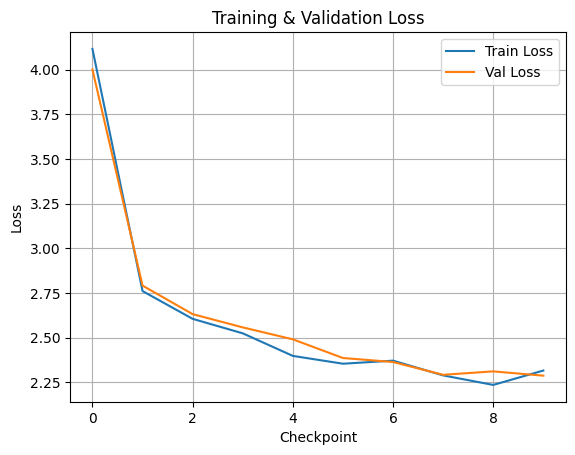

In [17]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Checkpoint')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
context = torch.zeros((1, 1), dtype=torch.long, device=device)
generated = model.generate(context, max_new_tokens=500, temperature=0.9, top_k=40)
print(decode(generated[0].tolist()))


To mean it?
CIOLINCHIUS:
Soo, aidn foou thest.
This gt make
Mese had, to wato nay theare wnime tow me withear,
NELOLA:
Hows goo, t sel
I I hip, trevee tud you peased melcith wa hins ad of the ther ence f not lovet wfor hre ownot wis thuspay I itis thou tothe a of he ines, ther toe not of this his thalge woraill I aper
Hin unsot witk sto wel wity his his inot. Coubthesst:
What his and the ber sores
Se I magy my oftach to mas,
I hou why is tcin hild;
e Hor.

Rut tame mis the some to,
Wen tour set,


In [ ]:
torch.save(model, "transformer_char_model.pt")